In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Mar  23 19:11:23 2019

@author: kushaldeb
"""

import os
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
# declaring the constants

batch_size = 64
epochs = 20
img_width, img_height = 100, 100
learn_rate = 2e-4
ngpus = 4
nclasses = 2

In [3]:
# path to save the model

model_path = 'models-inceptionv3'
top_weights_path = os.path.join(
    os.path.abspath(model_path), 'top_model_weights.h5')
final_weights_path = os.path.join(
    os.path.abspath(model_path), 'model_weights.h5')

train_data_dir = '/home/mia/kushal/bcd/Untitled/sample_dataset/Training/'
validation_data_dir = '/home/mia/kushal/bcd/Untitled/sample_dataset/Validation/'

In [6]:
# Initializing the model

base_model = InceptionV3(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(nclasses-1, activation='sigmoid')(x)
pmodel = Model(base_model.input, predictions)
pmodel.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization_v1[0][0]     
_____________________________________

In [7]:
# Preparing the training and validation set

train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)

training_data = train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  class_mode='binary')
validation_data = validation_datagen.flow_from_directory(validation_data_dir,
                                                         target_size=(img_width, img_height),
                                                         batch_size=batch_size,
                                                         shuffle=False,
                                                         class_mode='binary')

Found 100000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [8]:
print(training_data.class_indices)
train_steps = training_data.__len__
validation_steps = validation_data.__len__

{'0': 0, '1': 1}


In [9]:
model = multi_gpu_model(pmodel, ngpus)

for layer in model.layers:
    layer.trainable = True
nadam = Nadam(lr = learn_rate)
print('=> creating model replicas for distributed training across {ngpus} gpus <=')
model.compile(optimizer = nadam,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
print('=> done building model <=')

=> creating model replicas for distributed training across {ngpus} gpus <=
=> done building model <=


In [10]:
tensorboard = TensorBoard(
    log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='batch')
callbacks_list = [ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
                  tensorboard, EarlyStopping(monitor='val_loss', patience=3, verbose=1)]
print('=> created callback objects <=')

=> created callback objects <=


In [11]:
print('=> initializing training loop <=')
history = model.fit_generator(training_data,
                              steps_per_epoch = train_steps,
                              epochs = epochs,
                              validation_data = validation_data,
                              validation_steps = validation_steps,
                              workers = 8,
                              #use_multiprocessing = True,
                              max_queue_size = 500,
                              callbacks = callbacks_list)

=> initializing training loop <=
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
157/157 [==============================] - 22s 142ms/step - loss: 0.3742 - acc: 0.8592

Epoch 00001: val_acc improved from -inf to 0.85920, saving model to /home/mia/kushal/bcd/Untitled/models-inceptionv3/model_weights.h5
1563/1563 [==============================] - 361s 231ms/step - loss: 0.3949 - acc: 0.8307 - val_loss: 0.3742 - val_acc: 0.8592
Epoch 2/20
157/157 [==============================] - 18s 117ms/step - loss: 0.8619 - acc: 0.8408

Epoch 00002: val_acc did not improve from 0.85920
1563/1563 [==============================] - 332s 212ms/step - loss: 0.3496 - acc: 0.8548 - val_loss: 0.8619 - val_acc: 0.8408
Epoch 3/20
157/157 [==============================] - 18s 118ms/step - loss: 0.3062 - acc: 0.8782

Epoch 00003: val_acc improved from 0.85920 to 0.87820, saving model to /home/mia/kushal/bcd/Untitled/models-inceptionv3/model_weights.h5
1563/1563 [==============================] - 33

In [12]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

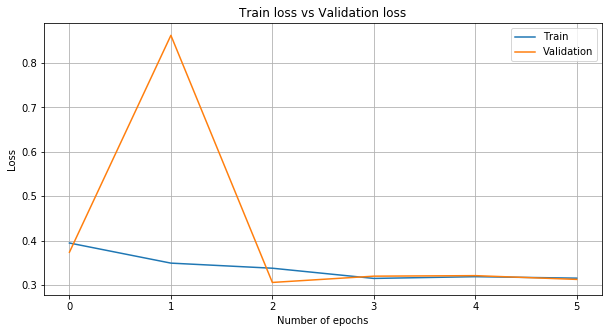

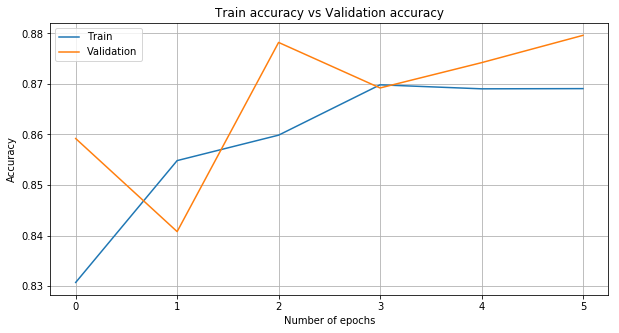

In [13]:
plt.figure(1, figsize=(10,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Train loss vs Validation loss')
plt.grid(True)
plt.legend(['Train', 'Validation'])

plt.figure(2, figsize=(10,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Train', 'Validation'])

In [14]:
# print('--------- Loading best weights ---------')
# pmodel.load_weights(final_weights_path)

print('---------- Saving final model ----------')
model.save(os.path.join(os.path.abspath(model_path), 'model.h5'))

---------- Saving final model ----------
